Loading tokenizer...
Loading model...


c:\Kanishka\My Programs\New Projects\Model Interpretation\helpers.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tokenizer = torch.load(os.path.join(save_dir, model_na

Optimizing input of length 10 to maximize output logits for " world"
Epoch 10/100, Loss: 1.4564, Prob Loss: 1.5674, Dist Loss: -0.1111
Epoch 20/100, Loss: 0.0622, Prob Loss: 0.2490, Dist Loss: -0.1868
Epoch 30/100, Loss: -0.1825, Prob Loss: 0.0453, Dist Loss: -0.2277
Epoch 40/100, Loss: -0.2428, Prob Loss: 0.0141, Dist Loss: -0.2569
Epoch 50/100, Loss: -0.2746, Prob Loss: 0.0082, Dist Loss: -0.2828
Epoch 60/100, Loss: -0.3026, Prob Loss: 0.0061, Dist Loss: -0.3087
Epoch 70/100, Loss: -0.3308, Prob Loss: 0.0050, Dist Loss: -0.3359
Epoch 80/100, Loss: -0.3604, Prob Loss: 0.0044, Dist Loss: -0.3647
Epoch 90/100, Loss: -0.3915, Prob Loss: 0.0039, Dist Loss: -0.3954
Epoch 100/100, Loss: -0.4243, Prob Loss: 0.0035, Dist Loss: -0.4278
Optimization complete!
Optimized Words:
[' answ', 'Particip', ' Isabel', ' caliphate', '458', ' 802', 'Spoiler', ' Actions', 'Again', ' pharmacy', ' Revised', 'xious', ' thri', ' Commonwealth', ' unnecessary', ' concluded', 'ffff', ' academy', ' Wor', ' circum',

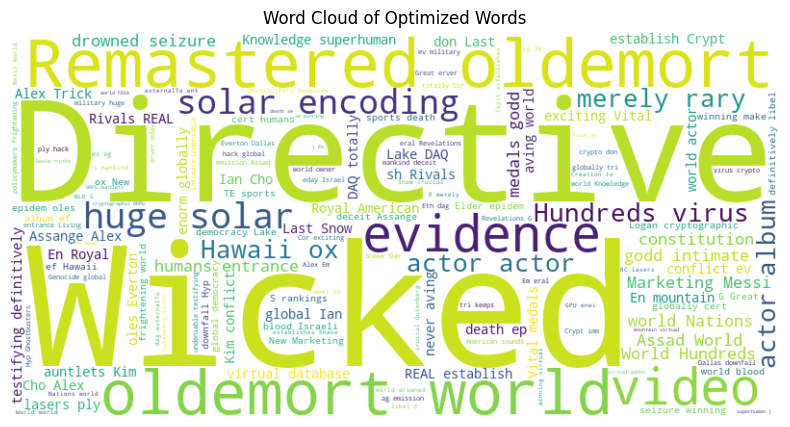

In [1]:
import torch
import numpy as np
import random
from helpers import load_all, closest_tokens, model_emb
from wordcloud import WordCloud
import matplotlib.pyplot as plt


device = "cpu"

# Initialize inputs
def initialize_inputs(word_embeddings, input_len, batch_size, method='random'):
    if method == 'random':
        start_input = word_embeddings[torch.randperm(word_embeddings.shape[0])[:input_len * batch_size]].reshape(
            batch_size, input_len, -1)
    else:
        raise ValueError("Unsupported initialization method")
    return torch.nn.Parameter(start_input.to(device), requires_grad=True)

# Optimize inputs
def optimize_inputs(
    model, tokenizer, word_embeddings, device, target_output, input_len=10,
    batch_size=20, epochs=100, lr=0.1, dist_reg=0.1, verbose=1
):
    print(f'Optimizing input of length {input_len} to maximize output logits for "{target_output}"')

    # Tokenize the target output
    output_ix = tokenizer.encode(target_output, return_tensors='pt')[0].to(device)
    output_len = output_ix.shape[0]

    # Normalize embeddings
    word_embeddings = word_embeddings / torch.sqrt(torch.sum(word_embeddings**2, dim=-1, keepdim=True))

    # Initialize inputs
    input_embeds = initialize_inputs(word_embeddings, input_len, batch_size)

    # Optimizer
    optimizer = torch.optim.Adam([input_embeds], lr=lr)

    all_optimized_words = []  # Store all decoded words

    for epoch in range(epochs):
        logits, emb = model_emb(model, input_embeds, word_embeddings, output_len)
        log_probs = torch.log_softmax(logits, dim=-1)
        target_log_probs = log_probs[:, torch.arange(output_len), output_ix]
        prob_loss = -target_log_probs.mean()

        # Token distance regularization
        token_distances = []
        for batch in input_embeds:
            distances = []
            for embedding in batch:
                tokens, _, dist, _ = closest_tokens(embedding, word_embeddings, tokenizer)
                distances.append(dist)
                all_optimized_words.extend(tokens)  # Collect optimized words
            token_distances.append(torch.stack(distances))
        dist_loss = torch.stack(token_distances).mean() * dist_reg

        total_loss = prob_loss + dist_loss
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if verbose and (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss.item():.4f}, Prob Loss: {prob_loss.item():.4f}, Dist Loss: {dist_loss.item():.4f}")

    print("Optimization complete!")
    return input_embeds, all_optimized_words

# Generate a word cloud
def create_word_cloud(words):
    # Join words into a single string
    text = " ".join(words)
    
    # Create a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud of Optimized Words")
    plt.show()

# Main function
def main():
    # Configuration
    model_name = "gpt2"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    target_output = " world"
    input_len = 10
    batch_size = 20
    epochs = 100
    lr = 0.1
    dist_reg = 0.1

    # Load model, tokenizer, and embeddings
    model, word_embeddings, tokenizer = load_all(model_name, device)

    # Optimize inputs
    optimized_inputs, optimized_words = optimize_inputs(
        model, tokenizer, word_embeddings, device, target_output,
        input_len, batch_size, epochs, lr, dist_reg, verbose=1
    )

    # Output results
    print("Optimized Words:")
    print(optimized_words)

    # Create a word cloud
    create_word_cloud(optimized_words)

if __name__ == "__main__":
    main()


Loading tokenizer...
Loading model...
Optimizing input of length 10 to maximize output logits for "engineer"
Epoch 10/100, Loss: 1.9470, Prob Loss: 2.0966, Dist Loss: -0.1496
Epoch 20/100, Loss: 0.2381, Prob Loss: 0.4751, Dist Loss: -0.2370
Epoch 30/100, Loss: 0.2728, Prob Loss: 0.5573, Dist Loss: -0.2845
Epoch 40/100, Loss: 0.2411, Prob Loss: 0.5580, Dist Loss: -0.3169
Epoch 50/100, Loss: 0.1497, Prob Loss: 0.4946, Dist Loss: -0.3449
Epoch 60/100, Loss: 0.0302, Prob Loss: 0.4026, Dist Loss: -0.3725
Epoch 70/100, Loss: -0.0211, Prob Loss: 0.3803, Dist Loss: -0.4013
Epoch 80/100, Loss: -0.0604, Prob Loss: 0.3716, Dist Loss: -0.4320
Epoch 90/100, Loss: -0.1003, Prob Loss: 0.3643, Dist Loss: -0.4645
Epoch 100/100, Loss: -0.1435, Prob Loss: 0.3554, Dist Loss: -0.4989
Optimization complete!
Optimized Words:
['und', ' Zimbabwe', '529', 'upt', 'ars', ' lob', ' Betty', ' belong', 'bourne', ' regression', ' Holo', '154', ' Memory', ' promises', ' builds', ' gruesome', ' metres', ' redesigned', 

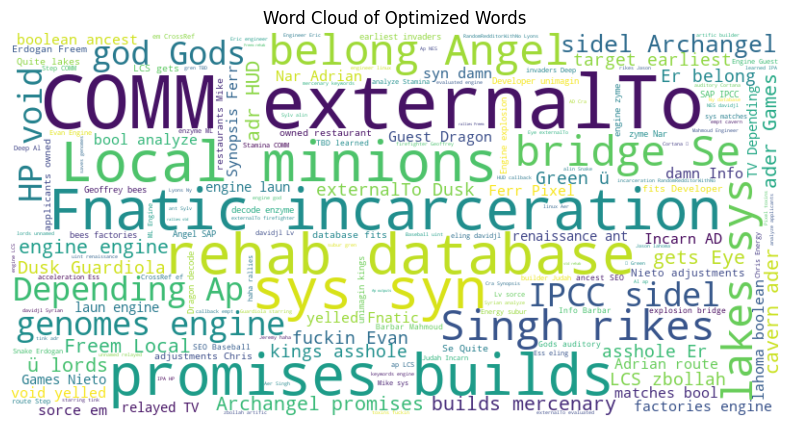

In [3]:
def main():
    # Configuration
    model_name = "gpt2"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    target_output = "engineer"
    input_len = 10
    batch_size = 20
    epochs = 100
    lr = 0.1
    dist_reg = 0.1

    # Load model, tokenizer, and embeddings
    model, word_embeddings, tokenizer = load_all(model_name, device)

    # Optimize inputs
    optimized_inputs, optimized_words = optimize_inputs(
        model, tokenizer, word_embeddings, device, target_output,
        input_len, batch_size, epochs, lr, dist_reg, verbose=1
    )

    # Output results
    print("Optimized Words:")
    print(optimized_words)

    # Create a word cloud
    create_word_cloud(optimized_words)

if __name__ == "__main__":
    main()

Loading tokenizer...
Loading model...
Optimizing input of length 10 to maximize output logits for "girl"
Epoch 10/100, Loss: 0.8204, Prob Loss: 0.9516, Dist Loss: -0.1312
Epoch 20/100, Loss: 0.2166, Prob Loss: 0.4251, Dist Loss: -0.2085
Epoch 30/100, Loss: 0.0535, Prob Loss: 0.3049, Dist Loss: -0.2513
Epoch 40/100, Loss: -0.2807, Prob Loss: 0.0020, Dist Loss: -0.2827
Epoch 50/100, Loss: -0.3098, Prob Loss: 0.0010, Dist Loss: -0.3108
Epoch 60/100, Loss: -0.3381, Prob Loss: 0.0008, Dist Loss: -0.3389
Epoch 70/100, Loss: -0.3676, Prob Loss: 0.0007, Dist Loss: -0.3684
Epoch 80/100, Loss: -0.3990, Prob Loss: 0.0007, Dist Loss: -0.3997
Epoch 90/100, Loss: -0.4323, Prob Loss: 0.0006, Dist Loss: -0.4329
Epoch 100/100, Loss: -0.4675, Prob Loss: 0.0006, Dist Loss: -0.4680
Optimization complete!
Optimized Words:
[' bit', 'epend', 'Cell', ' skilled', ' thereto', ' Fer', ' eg', 'NR', ' Spit', ' overshadow', 'Tap', 'reon', ' satisfactory', ' meanings', ':]', ' decode', ' Viktor', 'ographer', 'Isa', 

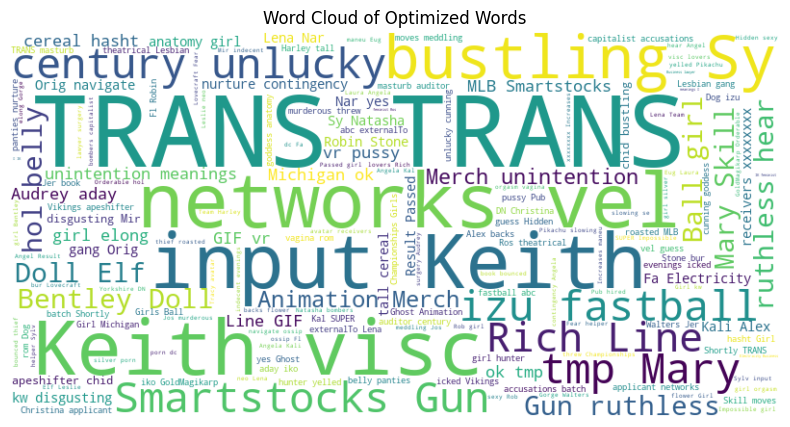

In [7]:
def main():
    # Configuration
    model_name = "gpt2"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    target_output = "girl"
    input_len = 10
    batch_size = 20
    epochs = 100
    lr = 0.1
    dist_reg = 0.1

    # Load model, tokenizer, and embeddings
    model, word_embeddings, tokenizer = load_all(model_name, device)

    # Optimize inputs
    optimized_inputs, optimized_words = optimize_inputs(
        model, tokenizer, word_embeddings, device, target_output,
        input_len, batch_size, epochs, lr, dist_reg, verbose=1
    )

    # Output results
    print("Optimized Words:")
    print(optimized_words)

    # Create a word cloud
    create_word_cloud(optimized_words)

if __name__ == "__main__":
    main()


Loading tokenizer...
Loading model...
Optimizing input of length 10 to maximize output logits for "I am a boy"
Epoch 10/100, Loss: 2.9330, Prob Loss: 3.0406, Dist Loss: -0.1076
Epoch 20/100, Loss: 1.0504, Prob Loss: 1.2367, Dist Loss: -0.1863
Epoch 30/100, Loss: 0.5462, Prob Loss: 0.7860, Dist Loss: -0.2398
Epoch 40/100, Loss: 0.1691, Prob Loss: 0.4549, Dist Loss: -0.2858
Epoch 50/100, Loss: -0.0195, Prob Loss: 0.3124, Dist Loss: -0.3319
Epoch 60/100, Loss: -0.1506, Prob Loss: 0.2307, Dist Loss: -0.3813
Epoch 70/100, Loss: -0.2449, Prob Loss: 0.1893, Dist Loss: -0.4342
Epoch 80/100, Loss: -0.3447, Prob Loss: 0.1456, Dist Loss: -0.4903
Epoch 90/100, Loss: -0.4233, Prob Loss: 0.1265, Dist Loss: -0.5498
Epoch 100/100, Loss: -0.5234, Prob Loss: 0.0894, Dist Loss: -0.6129
Optimization complete!
Optimized Words:
['BOOK', '2011', ' onslaught', 'esis', 'м', 'icient', 'Pay', 'ounters', ' Frankenstein', ' Patriot', ' 600', 'Beg', ' fortunate', ' diplomatic', 'ULL', ' bodies', ' Ender', ' Leslie'

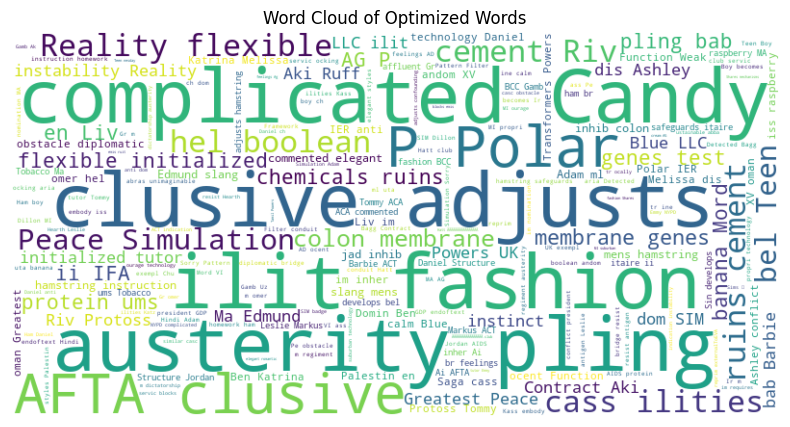

In [8]:
def main():
    # Configuration
    model_name = "gpt2"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    target_output = "I am a boy"
    input_len = 10
    batch_size = 20
    epochs = 100
    lr = 0.1
    dist_reg = 0.1

    # Load model, tokenizer, and embeddings
    model, word_embeddings, tokenizer = load_all(model_name, device)

    # Optimize inputs
    optimized_inputs, optimized_words = optimize_inputs(
        model, tokenizer, word_embeddings, device, target_output,
        input_len, batch_size, epochs, lr, dist_reg, verbose=1
    )

    # Output results
    print("Optimized Words:")
    print(optimized_words)

    # Create a word cloud
    create_word_cloud(optimized_words)

if __name__ == "__main__":
    main()


Loading tokenizer...
Loading model...
Optimizing input of length 10 to maximize output logits for "India"
Epoch 10/100, Loss: 1.8451, Prob Loss: 1.9670, Dist Loss: -0.1219
Epoch 20/100, Loss: 0.1832, Prob Loss: 0.3827, Dist Loss: -0.1995
Epoch 30/100, Loss: -0.2248, Prob Loss: 0.0168, Dist Loss: -0.2415
Epoch 40/100, Loss: -0.2626, Prob Loss: 0.0068, Dist Loss: -0.2694
Epoch 50/100, Loss: -0.2885, Prob Loss: 0.0041, Dist Loss: -0.2927
Epoch 60/100, Loss: -0.3121, Prob Loss: 0.0031, Dist Loss: -0.3152
Epoch 70/100, Loss: -0.3360, Prob Loss: 0.0025, Dist Loss: -0.3385
Epoch 80/100, Loss: -0.3610, Prob Loss: 0.0021, Dist Loss: -0.3631
Epoch 90/100, Loss: -0.3873, Prob Loss: 0.0019, Dist Loss: -0.3892
Epoch 100/100, Loss: -0.4151, Prob Loss: 0.0017, Dist Loss: -0.4168
Optimization complete!
Optimized Words:
['clave', 'isel', ' Sieg', ' Imag', 'Basic', 'despite', ' shooting', ' Focus', '─', ' emb', ' Ellison', ' endangered', ' offenders', ' lear', ' payroll', ' isot', ' Rober', 'Bob', ' ves

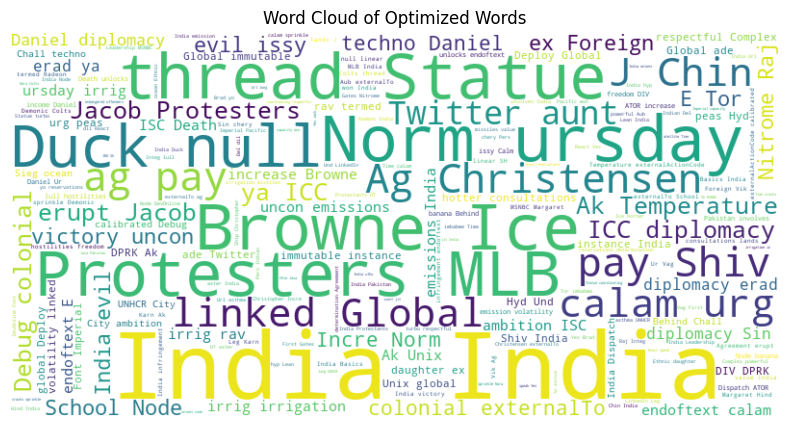

In [12]:
def main():
    # Configuration
    model_name = "gpt2"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    target_output = "India"
    input_len = 10
    batch_size = 20
    epochs = 100
    lr = 0.1
    dist_reg = 0.1

    # Load model, tokenizer, and embeddings
    model, word_embeddings, tokenizer = load_all(model_name, device)

    # Optimize inputs
    optimized_inputs, optimized_words = optimize_inputs(
        model, tokenizer, word_embeddings, device, target_output,
        input_len, batch_size, epochs, lr, dist_reg, verbose=1
    )

    # Output results
    print("Optimized Words:")
    print(optimized_words)

    # Create a word cloud
    create_word_cloud(optimized_words)

if __name__ == "__main__":
    main()
